## Red convolucional 3D multicapa ##
## Se selecciona la época 6, correspondiente al punto donde el modelo alcanza su mejor desempeño en la predicción de violencia en videos. Para ello, se carga el archivo model_checkpoint_ef_epoch_test_6.pth, el cual registra la mayor precisión en el conjunto de prueba (Test Accuracy: 0.8889)

In [1]:
# -------------------------------
# MÓDULOS DE PYTHON ESTÁNDAR / UTILIDADES
# -------------------------------

# Manejo del sistema de archivos y rutas
import os
# Manejo de advertencias (warnings)
import warnings
# Recolección de basura manual (liberar memoria)
import gc

# -------------------------------
# VISUALIZACIÓN Y DISPLAY
# -------------------------------

# Visualización de gráficos
import matplotlib.pyplot as plt
# Visualización de mapas de calor y análisis con seaborn
import seaborn as sns
# Mostrar elementos en Jupyter como tablas o imágenes
from IPython.display import display

# -------------------------------
# MANEJO DE DATOS
# -------------------------------

# Manipulación de datos tabulares
import pandas as pd
# Cálculos numéricos eficientes
import numpy as np

# -------------------------------
# VISIÓN POR COMPUTADOR
# -------------------------------

# OpenCV para leer y procesar imágenes o videos
import cv2

# -------------------------------
# PYTORCH
# -------------------------------

# Librería principal de PyTorch
import torch
# Submódulo para definir redes neuronales
from torch import nn
# Dataset y DataLoader para cargar datos
from torch.utils.data import DataLoader, Dataset
# Transformaciones de imágenes (normalización, conversión a tensor, etc.)
from torchvision import transforms

# -------------------------------
# MÉTRICAS
# -------------------------------

# Métricas de evaluación para clasificación
from sklearn.metrics import confusion_matrix, classification_report

# -------------------------------
# CONFIGURACIÓN GLOBAL
# -------------------------------

# Ignorar todos los warnings para evitar mensajes molestos en consola
warnings.filterwarnings("ignore")

In [2]:
# Modelo mejorado basado en una red neuronal convolucional 3D
class Improved3DCNN(nn.Module):
    # Constructor del modelo
    def __init__(self):
        # Llama al constructor de la clase base nn.Module
        super(Improved3DCNN, self).__init__()

        # Primera capa convolucional 3D: entrada de 3 canales (RGB), salida de 16
        self.conv1 = nn.Conv3d(3, 16, kernel_size=(3, 3, 3), padding=1)
        # Dropout para regularización después de la primera convolución
        self.dropout1 = nn.Dropout(0.2)
        # MaxPooling 3D que reduce las dimensiones espaciales (alto y ancho)
        self.pool = nn.MaxPool3d(kernel_size=(1, 2, 2))

        # Segunda capa convolucional: de 16 a 32 canales
        self.conv2 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=1)
        # Dropout después de la segunda convolución
        self.dropout2 = nn.Dropout(0.2)

        # Tercera capa convolucional: de 32 a 64 canales
        self.conv3 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=1)
        # Dropout después de la tercera convolución
        self.dropout3 = nn.Dropout(0.2)

        # Calcula automáticamente el tamaño que debe tener la primera capa fully connected
        self.fc_input_size = self._get_fc_input_size()

        # Primera capa completamente conectada: de fc_input_size a 128 neuronas
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        # Dropout en la capa densa para reducir overfitting
        self.dropout_fc = nn.Dropout(0.2)
        # Capa de salida: 2 neuronas (para clasificación binaria: violencia o no violencia)
        self.fc2 = nn.Linear(128, 2)

    # Método auxiliar para calcular dinámicamente el tamaño de entrada a la capa fc1
    def _get_fc_input_size(self):
        with torch.no_grad():  # No se calculan gradientes en este bloque
            # Simula un lote con una muestra, 3 canales, 30 frames de 224x224 píxeles
            x = torch.zeros(1, 3, 30, 224, 224)
            # Aplica conv1 + ReLU + pool
            x = self.pool(nn.functional.relu(self.conv1(x)))
            # Aplica conv2 + ReLU + pool
            x = self.pool(nn.functional.relu(self.conv2(x)))
            # Aplica conv3 + ReLU + pool
            x = self.pool(nn.functional.relu(self.conv3(x)))
            # Devuelve el número total de elementos como tamaño de entrada
            return x.numel()

    # Método de propagación hacia adelante del modelo
    def forward(self, x):
        # Primera capa: convolución + ReLU + pooling + dropout
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.dropout1(x)

        # Segunda capa: convolución + ReLU + pooling + dropout
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.dropout2(x)

        # Tercera capa: convolución + ReLU + pooling + dropout
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = self.dropout3(x)

        # Aplanar el tensor para pasarlo a las capas completamente conectadas
        x = x.view(-1, self.fc_input_size)

        # Capa densa + ReLU + dropout
        x = self.dropout_fc(nn.functional.relu(self.fc1(x)))

        # Capa de salida sin activación (se usará CrossEntropyLoss que incluye Softmax internamente)
        x = self.fc2(x)

        # Retorna la salida final del modelo
        return x  
    
# -----------------------------------------------------------
# Función para predecir la clase (violencia o no violencia) en nuevos videos
# -----------------------------------------------------------
def predict_new_videos(directory, model, transform, device):
    # Coloca el modelo en modo evaluación (desactiva dropout, batchnorm, etc.)
    model.eval()

    # Itera sobre todos los archivos del directorio especificado
    for video_file in os.listdir(directory):
        # Solo considera archivos con extensión .mp4
        if video_file.endswith('.mp4'):
            # Construye la ruta completa del video
            video_path = os.path.join(directory, video_file)

            # Abre el video con OpenCV
            cap = cv2.VideoCapture(video_path)
            frames = []  # Lista para almacenar los frames extraídos

            # Leer todos los frames del video
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break  # Si no hay más frames, salir del bucle

                # Redimensionar cada frame a 224x224 píxeles
                frame = cv2.resize(frame, (224, 224))

                # Aplicar transformaciones si están definidas (ToTensor + Normalize)
                if transform:
                    frame = transform(frame)

                # Agregar el frame transformado a la lista
                frames.append(frame)

            # Cerrar el video
            cap.release()

            # Asegurar que el video tenga exactamente 30 frames
            if len(frames) < 30:
                # Si hay menos de 30, rellenar con tensores de ceros
                frames += [torch.zeros(3, 224, 224)] * (30 - len(frames))
            # Si hay más de 30, recortar los primeros 30
            frames = frames[:30]

            # Convertir la lista de frames en un solo tensor: [T, C, H, W] → [C, T, H, W]
            frames = torch.stack(frames).permute(1, 0, 2, 3)
            # Añadir dimensión de batch y mover al dispositivo (GPU o CPU)
            frames = frames.unsqueeze(0).to(device)

            # Hacer predicción sin calcular gradientes
            with torch.no_grad():
                # Obtener la salida del modelo
                output = model(frames)
                # Obtener la clase con mayor probabilidad
                _, predicted = torch.max(output.data, 1)

                # Imprimir resultado con nombre del archivo y predicción
                print(f'Video: {video_file}, Predicted: {"Violence" if predicted.item() == 1 else "NonViolence"}')


# -----------------------------------------------------------
# Transformaciones aplicadas a cada frame antes de la predicción
# -----------------------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),  # Convierte imágenes en tensores [C, H, W]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normaliza a rango [-1, 1]
])

# -----------------------------------------------------------
# Inicialización del dispositivo de cómputo (GPU si está disponible, si no CPU)
# -----------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------------------------------------
# Cargar el modelo mejorado y moverlo al dispositivo (para inferencia)
# -----------------------------------------------------------
model = Improved3DCNN().to(device)

## Matriz de confusión y métricas

Train Metrics:
Classification Report:


,precision,recall,f1-score,support
0,0.86,0.97,0.91,106
1,0.97,0.84,0.90,106
accuracy,0.91,0.91,0.91,1
macro avg,0.91,0.91,0.91,212
weighted avg,0.91,0.91,0.91,212


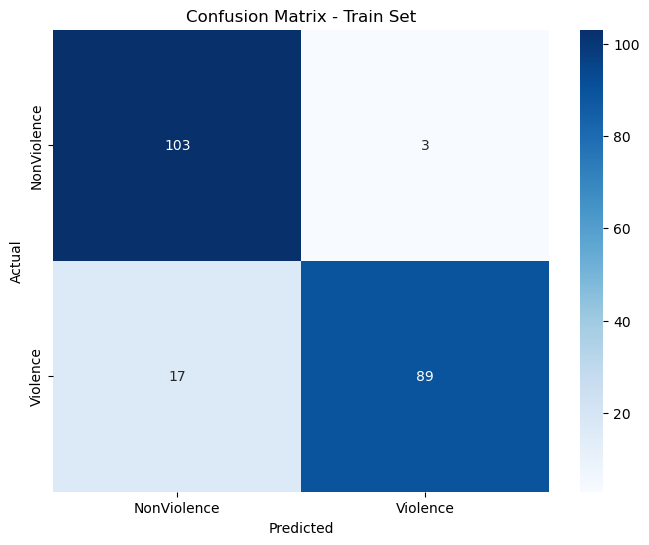

Test Metrics:
Classification Report:


,precision,recall,f1-score,support
0,0.89,0.89,0.89,27
1,0.89,0.89,0.89,27
accuracy,0.89,0.89,0.89,1
macro avg,0.89,0.89,0.89,54
weighted avg,0.89,0.89,0.89,54


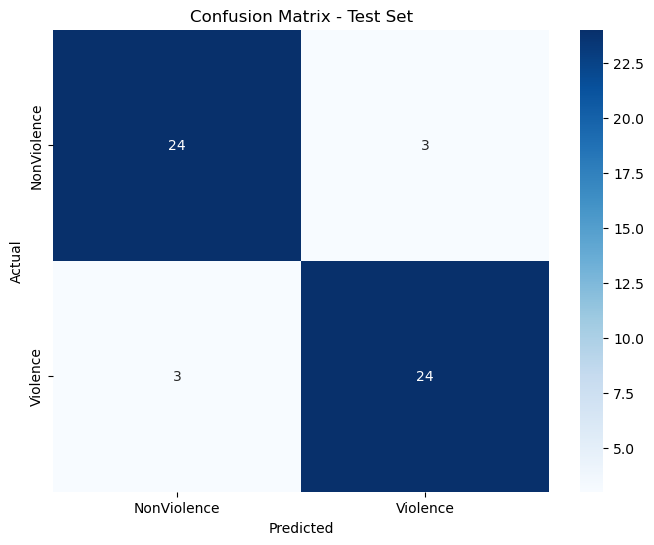

In [3]:
# -----------------------------------------------------------
# Clase personalizada para cargar videos desde carpetas etiquetadas
# -----------------------------------------------------------
class VideoDataset(Dataset):
    # Constructor de la clase. Recibe el directorio base y transformaciones opcionales
    def __init__(self, directory, transform=None):
        self.directory = directory  # Ruta al directorio de datos
        self.transform = transform  # Transformaciones opcionales para los frames
        self.videos = []  # Lista para almacenar las rutas de los videos
        self.labels = []  # Lista para almacenar las etiquetas (1 para 'Violence', 0 para 'NonViolence')

        # Recorre las subcarpetas 'Violence' y 'NonViolence' dentro del directorio
        for label in ['Violence', 'NonViolence']:
            path = os.path.join(self.directory, label)  # Ruta a la subcarpeta correspondiente
            for video_file in os.listdir(path):  # Itera sobre todos los archivos del directorio
                if video_file.endswith('.mp4'):  # Solo procesa archivos .mp4
                    self.videos.append(os.path.join(path, video_file))  # Guarda ruta completa del video
                    self.labels.append(1 if label == 'Violence' else 0)  # Asigna etiqueta binaria según clase

    # Devuelve la cantidad total de videos en el dataset
    def __len__(self):
        return len(self.videos)

    # Devuelve un video procesado (como tensor) y su etiqueta, dado un índice
    def __getitem__(self, idx):
        video_path = self.videos[idx]  # Ruta del video actual
        label = self.labels[idx]       # Etiqueta correspondiente

        # Abre el video usando OpenCV
        cap = cv2.VideoCapture(video_path)
        frames = []  # Lista para almacenar los frames extraídos

        # Lee todos los frames del video
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            # Redimensiona el frame a 224x224 píxeles
            frame = cv2.resize(frame, (224, 224))
            # Aplica las transformaciones (ToTensor, Normalize, etc.)
            if self.transform:
                frame = self.transform(frame)
            # Agrega el frame a la lista
            frames.append(frame)

        # Cierra el archivo de video
        cap.release()

        # Si hay menos de 30 frames, rellena con tensores de ceros
        if len(frames) < 30:
            frames += [torch.zeros(3, 224, 224)] * (30 - len(frames))

        # Si hay más de 30, se queda solo con los primeros 30
        frames = frames[:30]

        # Convierte la lista de frames a un tensor de forma [T, C, H, W]
        frames = torch.stack(frames)

        # Cambia la forma del tensor a [C, T, H, W] para CNN 3D
        frames = frames.permute(1, 0, 2, 3)

        # Retorna los frames procesados y su etiqueta correspondiente
        return frames, label

# -----------------------------------------------------------
# Inicialización del modelo y selección del dispositivo
# -----------------------------------------------------------
# Define si se usará GPU (si está disponible) o CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crea una instancia del modelo mejorado y lo mueve al dispositivo
model = Improved3DCNN().to(device)

# -----------------------------------------------------------
# Carga del checkpoint previamente entrenado
# -----------------------------------------------------------
# Carga el archivo del checkpoint guardado en la época 6
checkpoint = torch.load('/home/michell-alvarez/e_modelos/EF/model_checkpoint_ef_epoch_test_6.pth')

# Restaura los pesos del modelo con el estado guardado
model.load_state_dict(checkpoint['model_state_dict'])

# -----------------------------------------------------------
# Directorios de los conjuntos de datos
# -----------------------------------------------------------
# Ruta del conjunto de entrenamiento
train_dir = '/home/michell-alvarez/e_modelos/EF/Violencia/Train'

# Ruta del conjunto de prueba
test_dir = '/home/michell-alvarez/e_modelos/EF/Violencia/Test'

# -----------------------------------------------------------
# Transformaciones para los datos de entrada
# -----------------------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),  # Convierte los frames a tensores [C, H, W]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normaliza los valores de píxel a rango [-1, 1]
])

# -----------------------------------------------------------
# Creación de los datasets y DataLoaders para entrenamiento y prueba
# -----------------------------------------------------------

# Crea el dataset de entrenamiento aplicando las transformaciones definidas
train_dataset = VideoDataset(train_dir, transform)

# Crea el dataset de prueba con las mismas transformaciones
test_dataset = VideoDataset(test_dir, transform)

# Crea el DataLoader para entrenamiento, con shuffle activado y uso eficiente de memoria con pin_memory
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True)

# Crea el DataLoader para prueba, sin barajar los datos
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, pin_memory=True)

# -----------------------------------------------------------
# Función para evaluar el modelo y devolver etiquetas reales y predichas
# -----------------------------------------------------------
def evaluate(loader, model, device):
    y_true = []  # Lista para etiquetas verdaderas
    y_pred = []  # Lista para etiquetas predichas
    model.eval()  # Pone el modelo en modo evaluación (desactiva dropout, batchnorm, etc.)

    # Desactiva el cálculo de gradientes para mejorar el rendimiento
    with torch.no_grad():
        # Itera sobre los lotes del DataLoader
        for inputs, labels in loader:
            # Mueve los datos al dispositivo (GPU o CPU)
            inputs, labels = inputs.to(device), labels.to(device)
            # Predicción del modelo
            outputs = model(inputs)
            # Obtiene el índice de la clase con mayor puntuación
            _, predicted = torch.max(outputs.data, 1)
            # Convierte las etiquetas reales y predichas a listas en la CPU
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Devuelve arrays numpy con las etiquetas reales y predichas
    return np.array(y_true), np.array(y_pred)

# -----------------------------------------------------------
# Ejecuta la evaluación del modelo en los conjuntos de entrenamiento y prueba
# -----------------------------------------------------------

# Etiquetas reales y predichas del conjunto de entrenamiento
train_y_true, train_y_pred = evaluate(train_loader, model, device)

# Etiquetas reales y predichas del conjunto de prueba
test_y_true, test_y_pred = evaluate(test_loader, model, device)

# -----------------------------------------------------------
# Función para mostrar un reporte de métricas con estilo
# -----------------------------------------------------------
def print_metrics(y_true, y_pred):
    # Calcula el reporte de clasificación como diccionario
    report = classification_report(y_true, y_pred, output_dict=True)

    # Convierte el diccionario en un DataFrame para visualización
    report_df = pd.DataFrame(report).transpose()

    # Aplica estilo con fondo en gradiente azul y formato decimal
    styled_report = report_df.style.background_gradient(cmap='Blues').format({
        'precision': '{:.2f}',
        'recall': '{:.2f}',
        'f1-score': '{:.2f}',
        'support': '{:.0f}'
    })

    # Muestra el informe de clasificación estilizado
    print("Classification Report:")
    display(styled_report)

# -----------------------------------------------------------
# Función para graficar la matriz de confusión
# -----------------------------------------------------------
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    # Calcula la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Define tamaño del gráfico
    plt.figure(figsize=(8, 6))

    # Dibuja la matriz como mapa de calor
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['NonViolence', 'Violence'],
                yticklabels=['NonViolence', 'Violence'])

    # Etiquetas y título del gráfico
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# -----------------------------------------------------------
# Mostrar métricas y matriz de confusión del conjunto de entrenamiento
# -----------------------------------------------------------
print("Train Metrics:")
print_metrics(train_y_true, train_y_pred)
plot_confusion_matrix(train_y_true, train_y_pred, title='Confusion Matrix - Train Set')

# -----------------------------------------------------------
# Mostrar métricas y matriz de confusión del conjunto de prueba
# -----------------------------------------------------------
print("Test Metrics:")
print_metrics(test_y_true, test_y_pred)
plot_confusion_matrix(test_y_true, test_y_pred, title='Confusion Matrix - Test Set')

# -----------------------------------------------------------
# Liberar memoria de variables grandes para evitar saturación de RAM o GPU
# -----------------------------------------------------------
del train_dataset, test_dataset
del train_loader, test_loader
del train_y_true, train_y_pred, test_y_true, test_y_pred
del model, checkpoint

# Llama al recolector de basura de Python para liberar memoria ocupada por objetos no referenciados
gc.collect()

# Libera la memoria cacheada en la GPU (útil cuando se trabaja con CUDA)
torch.cuda.empty_cache()

## Boxplot comparativo de las dos distribuciones (antes y después) de cada métrica

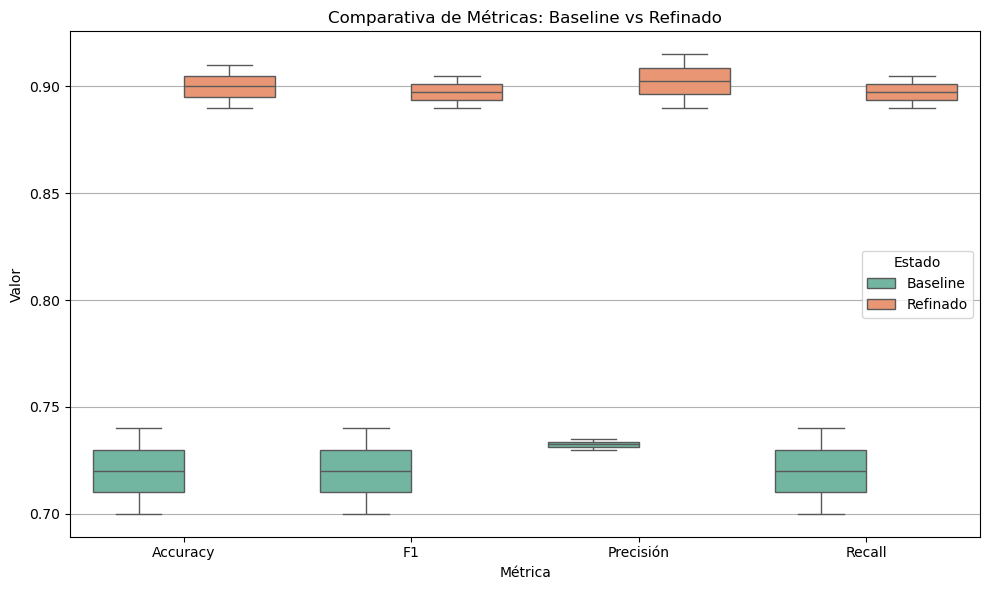

In [4]:
# -----------------------------------------------------------
# Diccionario con métricas de rendimiento para comparar los modelos de la semana 13 vs 14
# -----------------------------------------------------------
data = {
    # Lista de métricas repetidas (Accuracy, F1, Precisión, Recall) por grupo
    'Métrica': ['Accuracy', 'Accuracy', 'F1', 'F1', 'Precisión', 'Precisión', 'Recall', 'Recall'] * 2,

    # Valores correspondientes para cada métrica:
    # primeros 8 valores: modelo Baseline, últimos 8: modelo Refinado
    'Valor': [
        0.740, 0.700, 0.740, 0.700, 0.735, 0.730, 0.740, 0.700,  # Baseline
        0.910, 0.890, 0.905, 0.890, 0.915, 0.890, 0.905, 0.890   # Refinado
    ],

    # Grupo al que pertenecen (solo una categoría para este ejemplo, pero puede extenderse)
    'Conjunto': ['Entrenamiento'] * 8 + ['Refinado'] * 8,

    # Indica si los valores pertenecen al modelo original (Baseline) o al mejorado (Refinado)
    'Estado': ['Baseline'] * 8 + ['Refinado'] * 8
}

# -----------------------------------------------------------
# Convertir el diccionario a un DataFrame de pandas
# -----------------------------------------------------------
df = pd.DataFrame(data)

# -----------------------------------------------------------
# Crear gráfico boxplot para comparar métricas entre ambos modelos
# -----------------------------------------------------------

# Define el tamaño de la figura del gráfico
plt.figure(figsize=(10, 6))

# Crear un boxplot con seaborn:
# x → tipo de métrica, y → valor numérico, hue → Baseline vs Refinado
sns.boxplot(x='Métrica', y='Valor', hue='Estado', data=df, palette='Set2')

# Agregar título al gráfico
plt.title('Comparativa de Métricas: Baseline vs Refinado')

# Etiqueta del eje Y
plt.ylabel('Valor')

# Mostrar líneas de cuadrícula en el eje Y para mejor visualización
plt.grid(axis='y')

# Ajustar automáticamente el espacio para que no se recorte nada
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## Red convolucional 3D con atención temporal ##
## Se selecciona la época 18, correspondiente al punto donde el modelo alcanza su mejor desempeño en la predicción de violencia en videos. Para ello, se carga el archivo mia_entrenamiento_3DCNN_atención temporal_test_18.pth, el cual registra la mayor precisión en el conjunto de prueba (Test Accuracy: 0.8333)

/tmp/ipykernel_5254/525895140.py:240: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)
Evaluando (Entrenamiento): 100%|██████████| 14/14 [00


Resultados para Entrenamiento:
              precision  recall  f1-score  support
NonViolence        0.85    0.94      0.89   106.00
Violence           0.94    0.83      0.88   106.00
accuracy           0.89    0.89      0.89     0.89
macro avg          0.89    0.89      0.89   212.00
weighted avg       0.89    0.89      0.89   212.00
Tabla de métricas guardada en: /home/michell-alvarez/e_modelos/EF/archivos_txt/tabla_metricas_entrenamiento.html


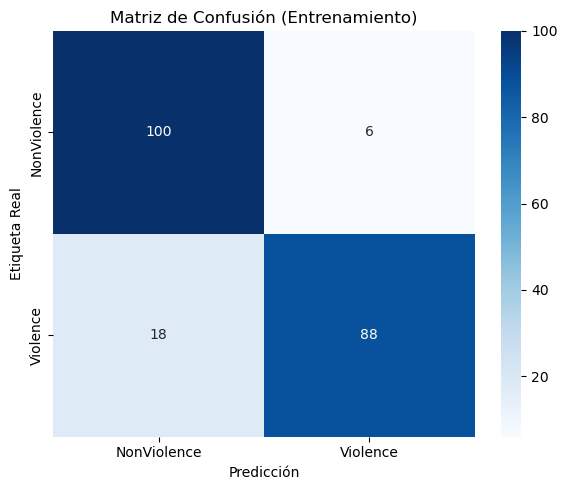

/tmp/ipykernel_5254/525895140.py:240: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Matriz de confusión guardada en: /home/michell-alvarez/e_modelos/EF/archivos_txt/matriz_confusion_entrenamiento.png
Reporte de texto guardado en: /home/michell-alvarez/e_modelos/EF/archivos_txt/resultados_entrenamiento.txt


Evaluando (Test): 100%|██████████| 4/4 [00:08<00:00,  2.14s/it]



Resultados para Test:
              precision  recall  f1-score  support
NonViolence        0.91    0.74      0.82    27.00
Violence           0.78    0.93      0.85    27.00
accuracy           0.83    0.83      0.83     0.83
macro avg          0.85    0.83      0.83    54.00
weighted avg       0.85    0.83      0.83    54.00
Tabla de métricas guardada en: /home/michell-alvarez/e_modelos/EF/archivos_txt/tabla_metricas_test.html


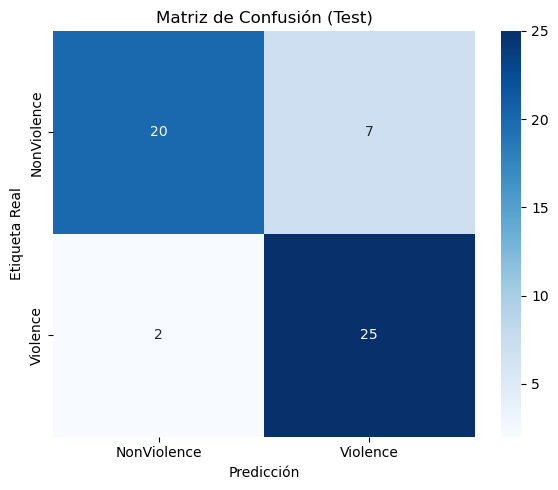

Matriz de confusión guardada en: /home/michell-alvarez/e_modelos/EF/archivos_txt/matriz_confusion_test.png
Reporte de texto guardado en: /home/michell-alvarez/e_modelos/EF/archivos_txt/resultados_test.txt


In [ ]:
# Importa el módulo para suprimir advertencias
import warnings
# Importa el módulo para manejar operaciones del sistema como rutas de archivos
import os
# Importa OpenCV para procesamiento de video
import cv2
# Importa PyTorch
import torch
# Importa NumPy para operaciones matemáticas
import numpy as np
# Importa los submódulos nn (redes neuronales) y optim (optimizadores) de PyTorch
from torch import nn, optim
# Importa clases para cargar datos y crear datasets personalizados
from torch.utils.data import DataLoader, Dataset
# Importa transformaciones estándar para imágenes
from torchvision import transforms
# Importa herramientas para entrenamiento de precisión mixta
from torch.cuda.amp import GradScaler, autocast
# Importa función para dividir conjuntos de datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split
# Importa función para generar reportes de clasificación
from sklearn.metrics import classification_report
# Importa PIL para manejar imágenes
from PIL import Image
# Importa el módulo random para generación de números aleatorios
import random
# Importa funciones adicionales de PyTorch como F.relu, F.softmax, etc.
import torch.nn.functional as F
# Importa barra de progreso para bucles
from tqdm import tqdm
# Importa módulo para medir tiempo de ejecución
import time
# Importa herramienta para visualizar gráficamente redes neuronales
from torchviz import make_dot
# Importa librería para visualización de entrenamiento de modelos
import hiddenlayer as hl
# Importa función para crear matriz de confusión
from sklearn.metrics import confusion_matrix
# Importa seaborn para visualizaciones estadísticas
import seaborn as sns
# Importa matplotlib para graficar
import matplotlib.pyplot as plt
# Importa pandas para manipular datos tabulares
import pandas as pd
# Importa librería para exportar DataFrames como imágenes
import dataframe_image as dfi

# Define el dispositivo de entrenamiento: usa GPU si está disponible, si no, usa CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Activa optimizaciones en CUDNN para mejorar el rendimiento si la entrada es de tamaño fijo
torch.backends.cudnn.benchmark = True
# Establece una semilla fija para reproducibilidad en PyTorch
torch.manual_seed(42)
# Establece una semilla fija para reproducibilidad en NumPy
np.random.seed(42)

# Clase personalizada para manejar videos como dataset
class ViolenceDataset(Dataset):
    # Constructor de la clase
    def __init__(self, video_paths, labels, transform=None, clip_len=30, frame_size=112, eval_mode=False):
        # Lista de rutas de los videos
        self.video_paths = video_paths
        # Lista de etiquetas asociadas a cada video
        self.labels = labels
        # Transformaciones a aplicar a cada frame
        self.transform = transform
        # Número de frames a extraer por video
        self.clip_len = clip_len
        # Tamaño al que se redimensiona cada frame
        self.frame_size = frame_size
        # Modo evaluación: se fija la semilla por índice
        self.eval_mode = eval_mode

    # Devuelve la cantidad de muestras en el dataset
    def __len__(self):
        return len(self.video_paths)
    
    # Devuelve una muestra específica del dataset
    def __getitem__(self, idx):
        # Abre el video en la posición idx
        cap = cv2.VideoCapture(self.video_paths[idx])
        frames = []
        
        # Obtiene el número total de frames del video
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Si hay suficientes frames para muestrear
        if total_frames >= self.clip_len:
            # Si está en modo evaluación, fija la semilla para consistencia
            if self.eval_mode:
                random.seed(idx)
                np.random.seed(idx)
            # Selecciona clip_len índices aleatorios únicos
            indices = sorted(random.sample(range(total_frames), self.clip_len))
        else:
            # Si no hay suficientes frames, usa todos los disponibles
            indices = list(range(total_frames))

        # Recorre los índices seleccionados
        for i in indices:
            # Posiciona el video en el frame deseado
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            # Lee el frame
            ret, frame = cap.read()
            if ret:
                # Convierte de BGR (OpenCV) a RGB
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                # Redimensiona el frame al tamaño deseado
                frame = cv2.resize(frame, (self.frame_size, self.frame_size))
                # Convierte a objeto PIL
                frame = Image.fromarray(frame)
                # Aplica transformaciones si se proporcionaron
                if self.transform:
                    frame = self.transform(frame)
                else:
                    # Convierte a tensor y normaliza si no se proporcionaron transformaciones
                    frame = transforms.ToTensor()(frame)
                    frame = transforms.Normalize([0.432, 0.398, 0.377], [0.228, 0.224, 0.225])(frame)
                # Agrega el frame a la lista
                frames.append(frame)
        
        # Libera el recurso de video
        cap.release()
        
        # Si no se alcanzó clip_len, se rellena con frames en negro
        while len(frames) < self.clip_len:
            frames.append(torch.zeros(3, self.frame_size, self.frame_size))
        
        # Retorna los frames apilados (como tensor 5D: [C, T, H, W]) y su etiqueta correspondiente
        return torch.stack(frames[:self.clip_len], dim=1).float(), torch.tensor(self.labels[idx], dtype=torch.long)


# Define una clase de red neuronal para detección de violencia en videos
class ViolenceDetector(nn.Module):
    # Inicializa el modelo
    def __init__(self, num_classes=2):
        # Llama al constructor de la clase padre (nn.Module)
        super().__init__()
        
        # Definición del backbone con capas 3D convolucionales para extraer características
        self.backbone = nn.Sequential(
            # Bloque 1: captura patrones espaciales (no hay profundidad temporal aún)
            nn.Conv3d(3, 64, kernel_size=(1,3,3), padding=(0,1,1)),
            nn.BatchNorm3d(64),
            nn.GELU(),
            nn.MaxPool3d((1,2,2)),

            # Bloque 2: captura patrones espaciales y temporales
            nn.Conv3d(64, 128, kernel_size=(3,3,3), padding=(1,1,1)),
            nn.BatchNorm3d(128),
            nn.GELU(),
            nn.MaxPool3d((1,2,2)),

            # Bloque 3: mayor profundidad temporal, reduce a 7x7 espacial
            nn.Conv3d(128, 256, kernel_size=(3,3,3), padding=(1,1,1)),
            nn.BatchNorm3d(256),
            nn.GELU(),
            nn.AdaptiveAvgPool3d((None, 7, 7))  # Reduce solo el espacio, no el tiempo
        )
        
        # Módulo de atención temporal para ponderar la importancia de cada frame
        self.temp_attention = nn.Sequential(
            nn.Linear(256*7*7, 256),  # Reduce dimensión del frame a 256
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)  # Produce un peso de atención por frame
        )
        
        # Clasificador final que predice la clase de violencia/no violencia
        self.classifier = nn.Sequential(
            nn.Linear(256*7*7, 512),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)  # Salida final con logits por clase
        )

    # Define el paso hacia adelante del modelo
    def forward(self, x):
        # Asegura que los datos estén en tipo float
        x = x.float()
        # Pasa los datos por el backbone convolucional
        features = self.backbone(x)
        # Descompone las dimensiones del tensor de salida
        B, C, T, H, W = features.shape
        # Reorganiza y aplana los frames: [B, T, C*H*W]
        features = features.permute(0, 2, 1, 3, 4).reshape(B, T, C*H*W)
        # Calcula los pesos de atención con softmax a lo largo del tiempo
        attn_weights = torch.softmax(self.temp_attention(features), dim=1)
        # Aplica los pesos de atención y suma los contextos
        context = (features * attn_weights).sum(dim=1)
        # Clasifica el contexto agregado
        return self.classifier(context)

# Función para evaluar un modelo entrenado usando un conjunto de datos etiquetado
def evaluate_model(model_path, data_dir, txt_output_path, png_output_path, html_output_path, nombre_conjunto):
    # Importa funciones necesarias para evaluación
    from sklearn.metrics import confusion_matrix, classification_report
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Define las rutas a los videos de violencia y no violencia
    violence_dir = os.path.join(data_dir, 'Violence')
    nonviolence_dir = os.path.join(data_dir, 'NonViolence')
    
    # Inicializa listas para rutas de video y etiquetas
    video_paths = []
    labels = []
    
    # Recorre archivos de la clase violencia
    for video_file in os.listdir(violence_dir):
        if video_file.endswith('.mp4'):
            video_paths.append(os.path.join(violence_dir, video_file))  # Ruta completa del video
            labels.append(1)  # Etiqueta 1 para violencia
    
    # Recorre archivos de la clase no violencia
    for video_file in os.listdir(nonviolence_dir):
        if video_file.endswith('.mp4'):
            video_paths.append(os.path.join(nonviolence_dir, video_file))  # Ruta completa del video
            labels.append(0)  # Etiqueta 0 para no violencia
    
    # Define las transformaciones a aplicar a cada frame del video
    transform = transforms.Compose([
        transforms.Resize((112, 112)),  # Redimensiona cada frame
        transforms.ToTensor(),  # Convierte a tensor
        transforms.Normalize([0.432, 0.398, 0.377], [0.228, 0.224, 0.225])  # Normalización estándar
    ])
    
    # Crea el dataset con las rutas y etiquetas, y activa modo evaluación
    dataset = ViolenceDataset(video_paths, labels, transform, eval_mode=True)
    dataset.eval_mode = True  # Refuerza el modo determinista para muestreo reproducible
    
    # Crea el DataLoader para procesar los datos por lotes
    loader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=8)

    # Instancia el modelo y lo mueve al dispositivo (GPU o CPU)
    model = ViolenceDetector().to(device)

    # Carga los pesos guardados desde el archivo de checkpoint
    checkpoint = torch.load(model_path)

    # Carga el estado del modelo (pesos) desde el checkpoint
    model.load_state_dict(checkpoint['model_state_dict'])

    # Establece el modelo en modo evaluación (desactiva dropout, batchnorm training)
    model.eval()
    
    # Inicializa listas para almacenar predicciones y etiquetas reales
    all_preds = []
    all_labels = []
    
    # Desactiva el cálculo del gradiente para acelerar la inferencia y ahorrar memoria
    with torch.no_grad():
        # Itera sobre el conjunto de evaluación usando barra de progreso
        for inputs, labels in tqdm(loader, desc=f"Evaluando ({nombre_conjunto})"):
            # Mueve los inputs al dispositivo (GPU o CPU)
            inputs = inputs.to(device)
            # Ejecuta el modelo y obtiene los outputs (logits)
            outputs = model(inputs)
            # Obtiene las predicciones: índice con mayor valor en logits
            _, preds = torch.max(outputs, 1)
            # Agrega predicciones a la lista (se mueve a CPU y se convierte en array)
            all_preds.extend(preds.cpu().numpy())
            # Agrega etiquetas reales a la lista
            all_labels.extend(labels.numpy())
    
    # Define los nombres de las clases
    class_names = ['NonViolence', 'Violence']

    # Calcula la matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)

    # Genera reporte detallado (accuracy, precisión, recall, F1) en formato diccionario
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=2, output_dict=True)

    # Genera el mismo reporte pero como string para impresión o guardado
    report_str = classification_report(all_labels, all_preds, target_names=class_names, digits=2)

    # Convierte el diccionario del reporte a DataFrame y transpone filas <-> columnas
    df_report = pd.DataFrame(report).T

    # Redondea los valores del DataFrame a 2 decimales
    df_report = df_report.round(2)

    # Imprime los resultados en consola
    print(f"\nResultados para {nombre_conjunto}:")
    print(df_report)
    
    # Aplica estilo visual al DataFrame (gradientes azules, centrado, etc.)
    styled_df = df_report.style\
        .background_gradient(cmap='Blues')\
        .format(precision=2)\
        .set_properties(**{'text-align': 'center'})\
        .set_table_styles([{
            'selector': 'th',
            'props': [('text-align', 'center')]
        }])

    # Guarda la tabla estilizada como archivo HTML
    styled_df.to_html(html_output_path)
    print(f"Tabla de métricas guardada en: {html_output_path}")

    # Crea figura para el heatmap de la matriz de confusión
    plt.figure(figsize=(6,5))
    # Genera heatmap con anotaciones y etiquetas
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusión ({nombre_conjunto})')
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Real')
    plt.tight_layout()

    # Guarda el gráfico como imagen PNG
    plt.savefig(png_output_path)
    plt.show()

    # Cierra la figura para liberar memoria
    plt.close()
    print(f"Matriz de confusión guardada en: {png_output_path}")

    # Guarda el reporte textual en un archivo .txt
    with open(txt_output_path, 'w') as f:
        f.write(f"== Resultados de evaluación: {nombre_conjunto} ==\n\n")
        f.write(report_str)

    # Confirma en consola que el reporte fue guardado
    print(f"Reporte de texto guardado en: {txt_output_path}")


# Punto de entrada principal del script: este bloque solo se ejecuta si el script es llamado directamente
if __name__ == "__main__":

    # Ruta al archivo del modelo entrenado (.pth) que contiene los pesos del modelo
    model_path = "/home/michell-alvarez/e_modelos/EF/mia_entrenamiento_3DCNN_atención temporal_test_18.pth"

    # --------------------------- EVALUACIÓN DEL CONJUNTO DE ENTRENAMIENTO ---------------------------

    # Llama a la función de evaluación para el conjunto de entrenamiento
    evaluate_model(
        model_path=model_path,  # Ruta al modelo
        data_dir="/home/michell-alvarez/e_modelos/EF/Violencia/Train",  # Ruta del conjunto de entrenamiento
        txt_output_path="/home/michell-alvarez/e_modelos/EF/archivos_txt/resultados_entrenamiento.txt",  # Ruta de guardado para el reporte en texto
        png_output_path="/home/michell-alvarez/e_modelos/EF/archivos_txt/matriz_confusion_entrenamiento.png",  # Ruta para guardar la matriz de confusión como imagen
        html_output_path="/home/michell-alvarez/e_modelos/EF/archivos_txt/tabla_metricas_entrenamiento.html",  # Ruta para guardar la tabla de métricas como HTML
        nombre_conjunto="Entrenamiento"  # Nombre que se mostrará en los títulos y reportes
    )
    
    # --------------------------- EVALUACIÓN DEL CONJUNTO DE TEST ---------------------------

    # Llama a la función de evaluación para el conjunto de prueba (test)
    evaluate_model(
        model_path=model_path,  # Ruta al modelo
        data_dir="/home/michell-alvarez/e_modelos/EF/Violencia/Test",  # Ruta del conjunto de prueba
        txt_output_path="/home/michell-alvarez/e_modelos/EF/archivos_txt/resultados_test.txt",  # Ruta de guardado para el reporte en texto
        png_output_path="/home/michell-alvarez/e_modelos/EF/archivos_txt/matriz_confusion_test.png",  # Ruta para guardar la matriz de confusión como imagen
        html_output_path="/home/michell-alvarez/e_modelos/EF/archivos_txt/tabla_metricas_test.html",  # Ruta para guardar la tabla de métricas como HTML
        nombre_conjunto="Test"  # Nombre que se mostrará en los títulos y reportes
    )


## Híbrido 3DCNN + LSTM ##
## Se selecciona la época 23, correspondiente al punto donde el modelo alcanza su mejor desempeño en la predicción de violencia en videos. Para ello, se carga el archivo mia_entrenamiento_Hybrid_CNN_LSTM_test_23, el cual registra la mayor precisión en el conjunto de prueba (Test Accuracy: 0.907)

              precision  recall  f1-score   support
NonViolence      0.9100  0.8585    0.8835  106.0000
Violence         0.8661  0.9151    0.8899  106.0000
accuracy         0.8868  0.8868    0.8868    0.8868
macro avg        0.8880  0.8868    0.8867  212.0000
weighted avg     0.8880  0.8868    0.8867  212.0000
✅ Resultados de entrenamiento guardados en /home/michell-alvarez/e_modelos/EF/archivos_txt
Accuracy: 0.8868, F1: 0.8899, Precision: 0.8661, Recall: 0.9151


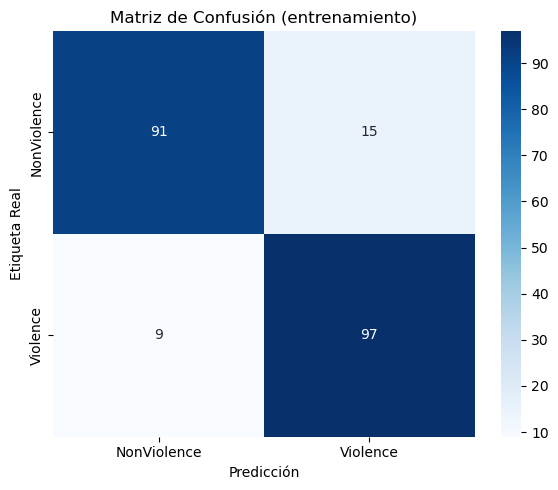

              precision  recall  f1-score  support
NonViolence      1.0000  0.8148    0.8980  27.0000
Violence         0.8438  1.0000    0.9153  27.0000
accuracy         0.9074  0.9074    0.9074   0.9074
macro avg        0.9219  0.9074    0.9066  54.0000
weighted avg     0.9219  0.9074    0.9066  54.0000
✅ Resultados de prueba guardados en /home/michell-alvarez/e_modelos/EF/archivos_txt
Accuracy: 0.9074, F1: 0.9153, Precision: 0.8438, Recall: 1.0000


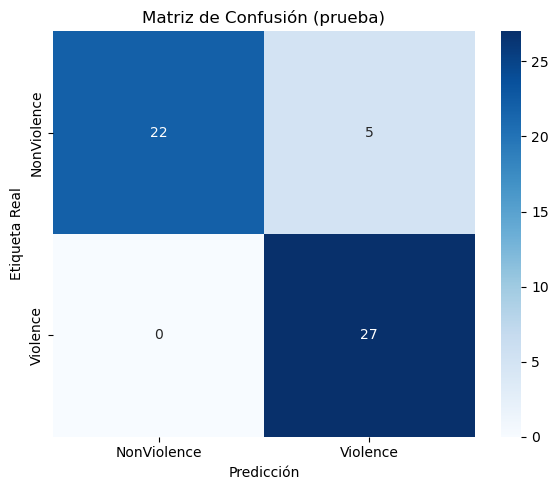

In [ ]:
# Importa el módulo para operaciones del sistema como rutas de archivos
import os
# Importa glob para buscar archivos con patrones específicos
import glob
# Importa OpenCV para leer y procesar videos
import cv2
# Importa el módulo random para operaciones aleatorias
import random
# Importa el módulo time para medir tiempos de ejecución
import time
# Importa el módulo warnings para ocultar advertencias
import warnings
# Importa PyTorch
import torch
# Importa funciones comunes de activación y pérdida de PyTorch
import torch.nn.functional as F
# Importa NumPy para operaciones numéricas
import numpy as np
# Importa pandas para manipular datos en tablas
import pandas as pd
# Importa matplotlib para generar gráficos
import matplotlib.pyplot as plt
# Importa seaborn para visualizaciones estadísticas
import seaborn as sns
# Importa submódulos para redes neuronales y optimizadores en PyTorch
from torch import nn, optim
# Importa clases para construir datasets personalizados y cargar datos
from torch.utils.data import Dataset, DataLoader
# Importa transformaciones de imágenes
from torchvision import transforms
# Importa métricas para evaluar clasificación
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

# Oculta todas las advertencias (warnings)
warnings.filterwarnings("ignore")

# -------------------------- Definición del Dataset Personalizado --------------------------

# Clase que hereda de torch.utils.data.Dataset para cargar videos y sus etiquetas
class VideoDataset(Dataset):
    # Constructor: inicializa el dataset con la ruta del directorio, transformaciones, etc.
    def __init__(self, directory, transform=None, frame_sample=30, is_train=False):
        self.directory = directory  # Carpeta raíz con subcarpetas de clases
        self.transform = transform  # Transformaciones opcionales
        self.frame_sample = frame_sample  # Cantidad de frames que se usarán por video
        self.is_train = is_train  # Indica si es entrenamiento (para aplicar augmentations)
        self.videos = []  # Lista de rutas de los videos
        self.labels = []  # Lista de etiquetas (1 o 0)

        # Recorre carpetas "Violence" y "NonViolence"
        for label in ['Violence', 'NonViolence']:
            path = os.path.join(self.directory, label)
            for video_file in os.listdir(path):
                if video_file.endswith('.mp4'):
                    self.videos.append(os.path.join(path, video_file))  # Guarda ruta completa del video
                    self.labels.append(1 if label == 'Violence' else 0)  # Etiqueta correspondiente

    # Devuelve la cantidad de muestras (videos) en el dataset
    def __len__(self):
        return len(self.videos)

    # Devuelve un elemento (video procesado y su etiqueta) según el índice
    def __getitem__(self, idx):
        video_path = self.videos[idx]  # Ruta al video
        label = self.labels[idx]  # Etiqueta correspondiente
        cap = cv2.VideoCapture(video_path)  # Abre el video con OpenCV
        frames = []  # Lista para almacenar los frames procesados

        # Lee los frames uno a uno
        while cap.isOpened():
            ret, frame = cap.read()  # Lee un frame
            if not ret:
                break  # Sale del bucle si no hay más frames

            # Convierte el frame de BGR a RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Redimensiona el frame a 224x224 píxeles
            frame = cv2.resize(frame, (224, 224))
            # Convierte el frame a tensor y lo normaliza a [0, 1]
            frame = torch.from_numpy(frame).float() / 255.0
            # Cambia el orden de canales de [H, W, C] a [C, H, W]
            frame = frame.permute(2, 0, 1)

            # Normalización con medias y desviaciones estándar de imagenes RGB (ImageNet)
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            frame = (frame - mean) / std  # Normaliza el frame

            # Agrega el frame a la lista
            frames.append(frame)

        # Libera el video
        cap.release()

        # Si hay más frames que los requeridos, se muestrean de forma equiespaciada
        if len(frames) > self.frame_sample:
            indices = np.linspace(0, len(frames)-1, num=self.frame_sample, dtype=int)
            frames = [frames[i] for i in indices]
        # Si hay menos, se duplican los últimos frames para llegar al total
        elif len(frames) < self.frame_sample:
            frames += [frames[-1]] * (self.frame_sample - len(frames))

        # Si es modo entrenamiento y hay transformaciones definidas, aplica data augmentation
        if self.transform and self.is_train and random.random() > 0.5:
            frames = [self.transform(frame) for frame in frames]

        # Apila los frames en un solo tensor con forma [N, C, H, W]
        frames = torch.stack(frames)
        # Reordena los ejes a [C, T, H, W] para redes 3D (Conv3D espera ese formato)
        frames = frames.permute(1, 0, 2, 3)

        # Devuelve los frames del video y su etiqueta
        return frames, label

# Define una clase de modelo híbrido CNN + LSTM + Atención
class Hybrid_CNN_LSTM(nn.Module):
    # Constructor del modelo
    def __init__(self, num_classes=2, cnn_out=128, lstm_hidden=128, lstm_layers=2):
        # Inicializa la clase base nn.Module
        super().__init__()

        # Define el extractor de características CNN en forma de bloques secuenciales
        self.cnn = nn.Sequential(
            self._make_conv_block(3, 32),               # Bloque 1: entrada con 3 canales (RGB)
            self._make_conv_block(32, 64),              # Bloque 2: salida 64 canales
            self._make_conv_block(64, 128),             # Bloque 3: salida 128 canales
            self._make_conv_block(128, cnn_out, pool=False),  # Bloque 4: salida cnn_out canales, sin pooling final
            nn.AdaptiveAvgPool2d((6, 6))                # Promedio adaptativo para reducir tamaño a (6x6)
        )

        # Define la capa LSTM que procesará secuencias de características de los frames
        self.lstm = nn.LSTM(
            input_size=cnn_out*6*6,      # Tamaño de entrada = salida CNN aplanada por frame
            hidden_size=lstm_hidden,     # Tamaño del estado oculto
            num_layers=lstm_layers,      # Número de capas LSTM
            bidirectional=True,          # Usa LSTM bidireccional para mejor contexto
            batch_first=True,            # El batch es la primera dimensión
            dropout=0.3 if lstm_layers > 1 else 0  # Dropout entre capas si hay más de una capa
        )

        # Módulo de atención sobre la salida LSTM
        self.attention = nn.Sequential(
            nn.Linear(lstm_hidden*2, lstm_hidden),  # Reduce dimensión de la salida bidireccional
            nn.Tanh(),                              # Activación no lineal
            nn.Linear(lstm_hidden, 1, bias=False)   # Proyecta a una puntuación escalar por paso de tiempo
        )

        # Clasificador final con capas totalmente conectadas
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden*2, lstm_hidden),  # Reduce dimensión
            nn.BatchNorm1d(lstm_hidden),            # Normalización de batch
            nn.LeakyReLU(0.2),                      # Activación LeakyReLU
            nn.Dropout(0.5),                        # Dropout para regularización
            nn.Linear(lstm_hidden, num_classes)     # Capa final de salida para clasificación
        )

        # Inicializa los pesos del modelo
        self._init_weights()

    # Crea un bloque convolucional: Conv2d + BatchNorm + LeakyReLU [+ MaxPool]
    def _make_conv_block(self, in_c, out_c, pool=True):
        block = [
            nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),  # Convolución 3x3 sin sesgo
            nn.BatchNorm2d(out_c),                             # Normalización de batch
            nn.LeakyReLU(0.2, inplace=True)                    # Activación LeakyReLU
        ]
        if pool:
            block.append(nn.MaxPool2d(2, ceil_mode=True))      # Agrega MaxPooling si está habilitado
        return nn.Sequential(*block)                           # Devuelve el bloque como secuencia

    # Inicializa los pesos de todas las capas del modelo
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Inicialización Kaiming para convoluciones
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d):
                # Inicialización de BatchNorm
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                # Inicialización Xavier para capas lineales
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    # Define el paso hacia adelante del modelo
    def forward(self, x):
        batch_size = x.size(0)   # Tamaño del batch
        seq_length = x.size(2)   # Longitud de la secuencia (número de frames)

        # Reorganiza tensor de entrada: [B, C, T, H, W] -> [B, T, C, H, W]
        c_in = x.permute(0, 2, 1, 3, 4)

        # Junta todos los frames en un solo batch: [B*T, C, H, W]
        c_in = c_in.reshape(-1, x.size(1), x.size(3), x.size(4))

        # Pasa por la CNN: extrae características espaciales por frame
        c_out = self.cnn(c_in)

        # Aplana la salida: [B*T, cnn_out, 6, 6] -> [B, T, cnn_out*6*6]
        c_out = c_out.view(batch_size, seq_length, -1)

        # Pasa la secuencia de características por la LSTM
        lstm_out, _ = self.lstm(c_out)

        # Calcula las puntuaciones de atención para cada paso temporal
        attention_scores = self.attention(lstm_out)

        # Calcula los pesos de atención usando softmax
        attention_weights = F.softmax(attention_scores, dim=1)

        # Aplica los pesos de atención para obtener el vector de contexto
        context_vector = torch.sum(lstm_out * attention_weights, dim=1)

        # Pasa el vector de contexto por el clasificador
        output = self.classifier(context_vector)

        # Devuelve la predicción final del modelo
        return output

# Función para evaluar el modelo en un DataLoader y guardar métricas, reportes y gráficos
def evaluar_modelo(loader, model, nombre_conjunto, ruta_salida):
    # Listas para almacenar predicciones y etiquetas verdaderas
    all_preds = []
    all_labels = []

    # Establece el modelo en modo evaluación (desactiva dropout/batchnorm)
    model.eval()
    # Desactiva el cálculo del gradiente (optimiza memoria e inferencia)
    with torch.no_grad():
        # Recorre el DataLoader por lotes
        for inputs, labels in loader:
            # Mueve los datos al dispositivo (GPU o CPU)
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Obtiene las predicciones del modelo
            outputs = model(inputs)
            # Toma la clase con mayor probabilidad como predicción
            _, preds = torch.max(outputs, 1)
            # Almacena las predicciones (en CPU)
            all_preds.extend(preds.cpu().numpy())
            # Almacena las etiquetas verdaderas (en CPU)
            all_labels.extend(labels.cpu().numpy())

    # --------------------- Cálculo de Métricas ---------------------

    # Calcula la exactitud (accuracy)
    accuracy = accuracy_score(all_labels, all_preds)
    # Calcula el F1-score
    f1 = f1_score(all_labels, all_preds)
    # Calcula la precisión
    precision = precision_score(all_labels, all_preds)
    # Calcula el recall
    recall = recall_score(all_labels, all_preds)
    
    # --------------------- Crear y Guardar Métricas ---------------------

    # Diccionario con las métricas calculadas
    metrics_dict = {
        'Accuracy': [accuracy],
        'F1 Score': [f1],
        'Precision': [precision],
        'Recall': [recall]
    }

    # Convierte el diccionario a un DataFrame
    df_metrics = pd.DataFrame(metrics_dict)
    
    # Guarda el DataFrame como archivo CSV en la ruta indicada
    df_metrics.to_csv(os.path.join(ruta_salida, f"metricas_{nombre_conjunto}.csv"), index=False)
    
    # --------------------- Matriz de Confusión ---------------------

    # Nombres de las clases para las etiquetas
    class_names = ['NonViolence', 'Violence']
    # Calcula la matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)
    
    # --------------------- Reporte de Clasificación ---------------------

    # Genera el reporte de clasificación como diccionario
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    # Convierte el reporte a DataFrame y redondea los valores
    df_report = pd.DataFrame(report).T.round(4)
    # Guarda el reporte como CSV
    df_report.to_csv(os.path.join(ruta_salida, f"reporte_clasificacion_{nombre_conjunto}.csv"))
    
    # Imprime el reporte en consola
    print(df_report)
    
    # --------------------- Guardar Imagen de la Matriz de Confusión ---------------------

    # Crea una figura para el heatmap
    plt.figure(figsize=(8, 6))
    # Define el color del mapa según el conjunto
    cmap = 'Blues' if nombre_conjunto == "entrenamiento" else 'Oranges'
    # Crea el heatmap con anotaciones, usando etiquetas de clase
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=class_names, yticklabels=class_names)
    # Agrega título con métricas al gráfico
    plt.title(f'Matriz de Confusión - {nombre_conjunto.capitalize()}\nAccuracy: {accuracy:.4f}, F1: {f1:.4f}')
    # Etiquetas de ejes
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Real')
    # Ajusta el diseño para evitar superposiciones
    plt.tight_layout()
    # Guarda la figura como imagen PNG en la ruta indicada
    plt.savefig(os.path.join(ruta_salida, f"matriz_confusion_{nombre_conjunto}.png"), dpi=300)
    # Cierra la figura para liberar memoria
    plt.close()

    
    # Crea una nueva figura para el gráfico de barras de métricas
    plt.figure(figsize=(8, 5))
    # Grafica el DataFrame de métricas como barras en el eje actual
    df_metrics.plot(kind='bar', ax=plt.gca())
    # Título del gráfico
    plt.title(f'Métricas de Rendimiento - {nombre_conjunto.capitalize()}')
    # Oculta etiquetas del eje x (porque solo hay una fila)
    plt.xticks([])
    # Etiqueta del eje Y
    plt.ylabel('Valor')
    # Límite del eje Y entre 0 y 1
    plt.ylim(0, 1)
    # Ubicación de la leyenda
    plt.legend(loc='lower right')
    # Ajusta el diseño del gráfico automáticamente
    plt.tight_layout()
    # Guarda el gráfico como imagen PNG
    plt.savefig(os.path.join(ruta_salida, f"metricas_{nombre_conjunto}.png"), dpi=300)
    # Cierra la figura para liberar memoria
    plt.close()

    # Imprime confirmación de guardado de resultados y métricas principales
    print(f" Resultados de {nombre_conjunto} guardados en {ruta_salida}")
    print(f"Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    # Crea figura para mostrar la matriz de confusión
    plt.figure(figsize=(6,5))
    # Dibuja el heatmap con anotaciones y etiquetas
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    # Título del gráfico con nombre del conjunto
    plt.title(f'Matriz de Confusión ({nombre_conjunto})')
    # Etiquetas de ejes
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Real')
    # Ajusta el layout automáticamente
    plt.tight_layout()
    # Muestra el gráfico en pantalla
    plt.show()
    # Cierra la figura para liberar memoria
    plt.close()


# ======================
# BLOQUE PRINCIPAL
# ======================
# Verifica si el script se está ejecutando directamente
if __name__ == "__main__":
    # Define el dispositivo: usa GPU si está disponible, si no, CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ------------------ Rutas necesarias ------------------

    # Ruta al checkpoint del modelo entrenado (.pth)
    checkpoint_path = '/home/michell-alvarez/e_modelos/EF/mia_entrenamiento_Hybrid_CNN_LSTM_test_23.pth'
    # Carpeta donde se guardarán resultados (csv, png, etc.)
    ruta_resultados = '/home/michell-alvarez/e_modelos/EF/archivos_txt'
    # Directorio con los videos de entrenamiento
    train_dir = '/home/michell-alvarez/e_modelos/EF/Violencia/Train'
    # Directorio con los videos de prueba
    test_dir = '/home/michell-alvarez/e_modelos/EF/Violencia/Test'

    # ------------------ Crear carpeta de salida si no existe ------------------

    # Crea la carpeta de resultados si aún no ha sido creada
    os.makedirs(ruta_resultados, exist_ok=True)

    # ------------------ Transformaciones (Data Augmentation) ------------------

    # Define una secuencia de transformaciones aleatorias para los frames de video
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),                          # Volteo horizontal aleatorio
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Ajuste aleatorio de brillo, contraste y saturación
        transforms.RandomAffine(degrees=10, translate=(0.1,0.1)),       # Rotación y traslación aleatoria
        transforms.Resize((224, 224)),                                  # Redimensiona el frame a 224x224
        transforms.Normalize(mean=[0.485, 0.456, 0.406],                # Normaliza según estadísticas de ImageNet
                             std=[0.229, 0.224, 0.225])
    ])

    # ------------------ Carga de Datos ------------------

    # Carga el dataset de entrenamiento con transformaciones y modo entrenamiento activo
    train_dataset = VideoDataset(train_dir, transform, is_train=True)
    # Carga el dataset de prueba sin aumentos de datos
    test_dataset = VideoDataset(test_dir, transform, is_train=False)

    # DataLoaders: agrupan los datos por lotes
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4, pin_memory=True)

    # ------------------ Carga del Modelo ------------------

    # Crea una instancia del modelo híbrido y lo mueve al dispositivo
    model = Hybrid_CNN_LSTM().to(device)

    # Carga los pesos entrenados desde el checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Carga los pesos al modelo desde el diccionario del checkpoint
    model.load_state_dict(checkpoint['model_state_dict'])  # Cambiar si solo se guardó el modelo directamente

    # Establece el modelo en modo evaluación
    model.eval()

    # ------------------ Evaluación ------------------

    # Evalúa el modelo en el conjunto de entrenamiento
    evaluar_modelo(train_loader, model, "entrenamiento", ruta_resultados)
    # Evalúa el modelo en el conjunto de prueba
    evaluar_modelo(test_loader, model, "prueba", ruta_resultados)

## Boxplot comparativo de Modelos para Detección de Violencia en Video

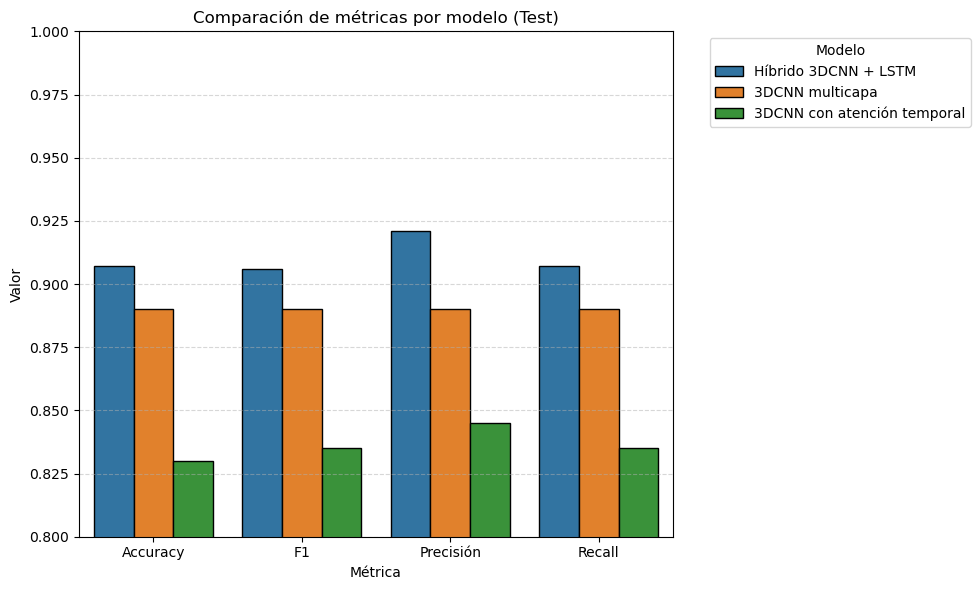

In [6]:
# Importa la librería pandas para manipulación de datos tabulares
import pandas as pd
# Importa matplotlib para crear gráficos
import matplotlib.pyplot as plt
# Importa seaborn para visualizaciones estadísticas más estéticas
import seaborn as sns

# ------------------- DATOS -------------------

# Define una lista de diccionarios con los resultados de evaluación de cada modelo
data = [
    # Métricas para el modelo Híbrido 3DCNN + LSTM
    {"Modelo": "Híbrido 3DCNN + LSTM", "Métrica": "Accuracy", "Valor": 0.907},
    {"Modelo": "Híbrido 3DCNN + LSTM", "Métrica": "F1", "Valor": 0.906},
    {"Modelo": "Híbrido 3DCNN + LSTM", "Métrica": "Precisión", "Valor": 0.921},
    {"Modelo": "Híbrido 3DCNN + LSTM", "Métrica": "Recall", "Valor": 0.907},

    # Métricas para el modelo 3DCNN multicapa
    {"Modelo": "3DCNN multicapa", "Métrica": "Accuracy", "Valor": 0.890},
    {"Modelo": "3DCNN multicapa", "Métrica": "F1", "Valor": 0.890},
    {"Modelo": "3DCNN multicapa", "Métrica": "Precisión", "Valor": 0.890},
    {"Modelo": "3DCNN multicapa", "Métrica": "Recall", "Valor": 0.890},

    # Métricas para el modelo 3DCNN con atención temporal
    {"Modelo": "3DCNN con atención temporal", "Métrica": "Accuracy", "Valor": 0.830},
    {"Modelo": "3DCNN con atención temporal", "Métrica": "F1", "Valor": 0.835},
    {"Modelo": "3DCNN con atención temporal", "Métrica": "Precisión", "Valor": 0.845},
    {"Modelo": "3DCNN con atención temporal", "Métrica": "Recall", "Valor": 0.835},
]

# Convierte la lista de diccionarios en un DataFrame de pandas
df = pd.DataFrame(data)

# ------------------- GRÁFICO -------------------

# Crea una figura de tamaño 10x6 pulgadas
plt.figure(figsize=(10, 6))

# Genera un gráfico de barras con seaborn
# Eje X: tipo de métrica, Eje Y: valor de la métrica, separadas por modelo
sns.barplot(data=df, x="Métrica", y="Valor", hue="Modelo", edgecolor="black")

# Agrega un título al gráfico
plt.title("Comparación de métricas por modelo (Test)")

# Define el rango del eje Y entre 0.8 y 1.0 para enfocar diferencias sutiles
plt.ylim(0.8, 1.0)

# Agrega una rejilla horizontal de fondo para facilitar comparación visual
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Ajusta la posición de la leyenda fuera del gráfico (a la derecha)
plt.legend(title="Modelo", bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajusta automáticamente márgenes para que todo se vea bien
plt.tight_layout()

# Guarda el gráfico como imagen PNG en la ruta especificada
plt.savefig("/home/michell-alvarez/e_modelos/EF/archivos_txt/comparacion_metricas_barplot_colores.png", dpi=300)

# Muestra el gráfico en pantalla
plt.show()